In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgba
import os
import sys
from tqdm.notebook import tqdm

# get version
print("Matplotlib version",mpl.__version__)

mpl.rc('font', family = 'Arial')
plt.ioff()
# read in results
data = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\averaged_LOD_RMSEP_results.csv")
# detailed results
detail_data = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\detailed_LOD_RMSEP_results.csv")

Matplotlib version 3.3.4


# Braga regions
CADILLAC ChemLIBS

In [2]:
cad = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\cadillac_spectra.csv")
peaks = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\braga_peaks.csv") 
noise = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\braga_noise_regions.csv") 

In [17]:
# plot defining things
height = 0.052
b_y = -.003
box_list = []
rcolor = '#8b8b8b'
base='black'
b_a =1
alpha = 0.5
lwidth=1
x_data = cad['wave']
y_data = cad['intensity']
peak_x = peaks['peak']
peak_y = peaks['intensity']
peak_labs = peaks['element']
size=70
mark="*"
mwidth=0.5
mcolor='goldenrod'
c_l = 'navy'
c_m = 'goldenrod'
llabel = 'LANL (ChemCam)'
mlabel = 'MHC (ChemLIBS)'
ysize = 12
lsize = 14
tsize = 16
klen = 5

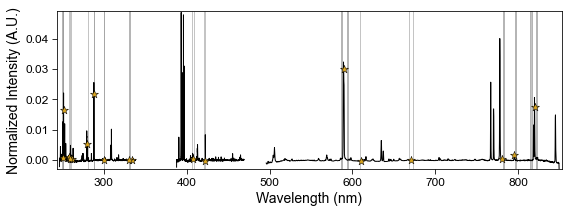

In [18]:
# get width of regions
noise['width'] = noise['stop'] - noise['start']

#make rectangles
for i in np.array(range(len(noise))):
    x = noise['start'][i]  
    width = noise['width'][i]
    box_list.append(Rectangle((x, b_y), width, height))
    
pc = PatchCollection(box_list, edgecolor = to_rgba(rcolor, alpha), facecolor=to_rgba(rcolor, alpha))
#pc = PatchCollection(box_list, hatch = '..')

# plot it all
fig, ax = plt.subplots(1, figsize = (8,3))
ax.plot(x_data, y_data, color=base, linewidth = lwidth, alpha = b_a, zorder=1) #spectrum
ax.scatter(peak_x, peak_y, facecolor = mcolor, edgecolor=base, s = size, marker = mark, linewidth = mwidth, zorder=3) # peaks
ax.add_collection(pc) # noise regions
ax.margins(x=0.005, y=0.0)
ax.set_xlabel('Wavelength (nm)', fontsize=lsize)
ax.set_ylabel('Normalized Intensity (A.U.)', fontsize = lsize)
ax.tick_params(length=klen, labelsize=ysize)

plt.tight_layout()
#plt.savefig('C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\braga_regions.eps', dpi=600)
plt.savefig('C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\braga_regions.jpg', dpi=600)
plt.show()

# Concentration boxplots

In [62]:
comps_path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\tables\\TableS1_sample_compositions.xlsx"
mhc_comps = pd.read_excel(comps_path, sheet_name='MHC')
lanl_comps = pd.read_excel(comps_path, sheet_name='LANL')

# remove units
mhc_comps.columns = mhc_comps.columns.str.strip(' (wt%)| (ppm)')
lanl_comps.columns = lanl_comps.columns.str.strip(' (wt%)| (ppm)')

# subsect into majors and minors
majors = ('SiO2|MnO|Na2O')
maj_mhc = mhc_comps.loc[:,mhc_comps.columns.str.contains(majors)]
maj_lanl = lanl_comps.loc[:,lanl_comps.columns.str.contains(majors)]
min_mhc = mhc_comps.loc[:,~mhc_comps.columns.str.contains(majors+'|Sample')]
min_lanl = lanl_comps.loc[:,~lanl_comps.columns.str.contains(majors+'|Sample')]

#### Prepare boxplot data and formatting

In [63]:
maj_ticks = maj_mhc.columns
min_ticks = min_mhc.columns

maj_lanl_data = []
min_lanl_data = []
maj_mhc_data = []
min_mhc_data = []

# get outlier vals to later remove
out_elem = ['Na2O', 'MnO', 'Li', 'Ni', 'Pb', 'Rb', 'Sr', 'Zn']
out_vals = [15, 15, 285, 577, 219, 354, 739, 448]
outliers = pd.DataFrame({
        'element' : out_elem,
        'outlier' : out_vals
})

# get data in right format
for element in maj_ticks:
    if element == 'SiO2':
        maj_lanl_df = maj_lanl[element].dropna().tolist()   
        maj_lanl_data.append(maj_lanl_df)
        maj_mhc_df = maj_mhc[element].dropna().tolist()
        maj_mhc_data.append(maj_mhc_df)
    
    else:
        maj_lanl_df = maj_lanl[element].dropna().tolist()
        maj_mhc_df = maj_mhc[element].dropna().tolist()

        outlier = outliers[outliers['element'] == element]['outlier'].iloc[0]
        maj_lanl_df = [i for i in maj_lanl_df if i <= outlier]
        maj_mhc_df = [i for i in maj_mhc_df if i <= outlier]

        maj_lanl_data.append(maj_lanl_df)
        maj_mhc_data.append(maj_mhc_df)
    
for element in min_ticks:
    min_lanl_df = min_lanl[element].dropna().tolist()
    min_mhc_df = min_mhc[element].dropna().tolist()
        
    outlier = outliers[outliers['element'] == element]['outlier'].iloc[0]
    min_lanl_df = [i for i in min_lanl_df if i <= outlier]
    min_mhc_df = [i for i in min_mhc_df if i <= outlier]
    
    min_lanl_data.append(min_lanl_df)
    min_mhc_data.append(min_mhc_df)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
# set how outlier points look
flierprops = dict(marker='x', markeredgecolor='#c9c9c9', markersize=2)

#### Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


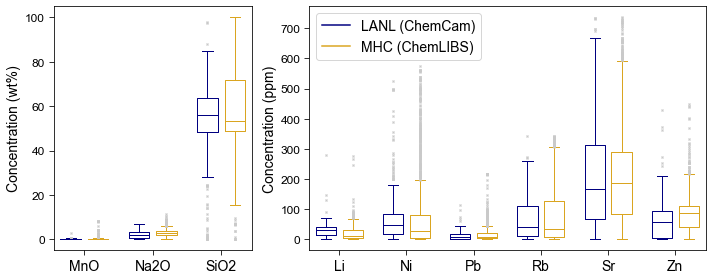

In [64]:
fig, (major, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                # make major one smaller
                                gridspec_kw={'width_ratios': [1,2]})

# box positions
maj_left_pos = np.array(range(len(maj_ticks)))*2.0-0.4
maj_right_pos = np.array(range(len(maj_ticks)))*2.0+0.4
min_left_pos = np.array(range(len(min_ticks)))*2.0-0.4
min_right_pos = np.array(range(len(min_ticks)))*2.0+0.4

# majors
bp_maj_lanl = major.boxplot(maj_lanl_data, flierprops=flierprops, positions = maj_left_pos, widths=0.6, showfliers=True)
bp_maj_mhc = major.boxplot(maj_mhc_data, flierprops=flierprops, positions = maj_right_pos, widths=0.6, showfliers=True)
set_box_color(bp_maj_lanl, c_l)
set_box_color(bp_maj_mhc, c_m)

# minors
bp_min_lanl = minor.boxplot(min_lanl_data, flierprops=flierprops, positions = min_left_pos, widths=0.6, showfliers=True)
bp_min_mhc = minor.boxplot(min_mhc_data, flierprops=flierprops, positions = min_right_pos, widths=0.6, showfliers=True)
set_box_color(bp_min_lanl, c_l)
set_box_color(bp_min_mhc, c_m)
 
# set plot labels
major.set_xticks(range(0, len(maj_ticks) * 2, 2))
major.set_xticklabels(maj_ticks, fontsize=lsize)
major.tick_params(axis = 'y', which = 'major', labelsize = ysize) 
major.set_ylabel('Concentration (wt%)', fontsize=lsize)
major.tick_params(length=klen)

minor.set_xticks(range(0, len(min_ticks) * 2, 2))
minor.set_xticklabels(min_ticks, fontsize=lsize)
minor.tick_params(axis = 'y', which = 'major', labelsize = ysize) 
minor.set_ylabel('Concentration (ppm)', fontsize=lsize)
minor.tick_params(length=klen)


plt.plot([], c=c_l, label=llabel)
plt.plot([], c=c_m, label=mlabel)
plt.legend(loc = 'best', fontsize=lsize)

plt.tight_layout()
plt.savefig('C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\comps_boxplot.eps')
plt.savefig('C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\comps_boxplot.jpg')
plt.show()

# Braga vs. metals
- ChemLIBS, Mars atmosphere
- LOQ and RMSE-P

In [65]:
data1 = data[(data.instrument == "ChemLIBS") & (data.atmosphere == "Mars")].copy(deep=True)

maj_list = ['MnO', 'Na2O', 'SiO2']
maj1 = pd.DataFrame(data1[data1.element.isin(maj_list)].reset_index(drop=True))
min1 = data1[~data1.element.isin(maj_list)].reset_index(drop=True)

### Bar plot

In [66]:
def braga_metals(lotype):
    
    # define variables
    braga = lotype + '_Braga'
    metals = lotype + '_metals'
    berror = lotype + '_Braga_sd'
    merror = lotype + '_metals_sd'
    
    # define plot stuff
    width = 0.2
    c_b = '#3a2382'
    c_m = '#f58442'
    cap= 3

    #labels
    majlab = maj1.element
    minlab = min1.element

    # tick locations
    majt1 = [0, 0.5, 1] 
    majt2 = [x + width for x in majt1]
    mint1 = np.arange(0,3,step=0.5)
    mint2 = [x + width for x in mint1]
    majtk = [x + width/2 for x in majt1]
    mintk = [x + width/2 for x in mint1]

    # make figure
    fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                     # make major one smaller
                                     gridspec_kw={'width_ratios': [1,2]})
    # majors
    major1 = maj.bar(majt1, maj1[braga], width, yerr=maj1[berror], capsize=cap, label = "Braga", color = c_b)
    major2 = maj.bar(majt2, maj1[metals], width, yerr=maj1[merror], capsize=cap, label = "metals", color = c_m)
    # minors
    minor1 = minor.bar(mint1, min1[braga], width, yerr=min1[berror], capsize=cap, label = "Braga", color = c_b)
    minor2 = minor.bar(mint2, min1[metals], width, yerr=min1[merror], capsize=cap, label = "metals", color = c_m)

    # formatting
    maj.tick_params(axis = 'y', which = 'major', labelsize = ysize,)
    maj.tick_params(length=klen)
    maj.set_xticks(majtk)
    maj.set_xticklabels(majlab, fontsize = lsize)
    maj.set_ylabel((lotype + " (wt%)"), fontsize = tsize)

    minor.set_xticks(mintk)
    minor.set_xticklabels(minlab, fontsize = lsize)
    minor.set_ylabel((lotype + " (ppm)"), fontsize = tsize)
    minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
    minor.tick_params(length=klen)
    minor.legend(handles = [major1, major2], fontsize = lsize)

    # save image
    path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\" + lotype + '_Braga_metals.eps'
    path1 = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\" + lotype + '_Braga_metals.jpeg'
    plt.savefig(path, bbox_inches="tight") # save as .eps
    plt.savefig(path1, bbox_inches="tight") # save as .jpeg
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


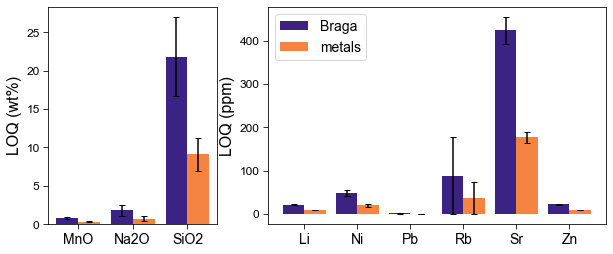

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


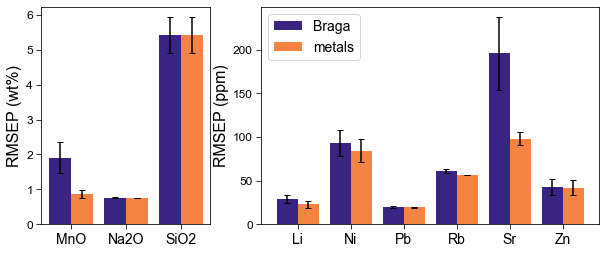

In [67]:
# make plots
braga_metals("LOQ")
braga_metals("RMSEP")

# LANL vs MHC
- Braga
- colors diff b/w instruments
- add data points for RMSE-P from Clegg
- X (RMSE) vs Y (R2) plot for CL/CC

In [68]:
data2 = data[data.atmosphere == "Mars"].copy(deep=True)
data2['RMSEP_per'] = round(((data2.RMSEP_Braga / data2.Avg_Braga) * 100), 1)
data2['RMSEP_sd_per'] = round(((data2.RMSEP_Braga_sd / data2.Avg_Braga) * 100), 1)

maj2 = data2[data2.element.isin(maj_list)].reset_index(drop=True)
min2 = data2[~data2.element.isin(maj_list)].reset_index(drop=True)
ldata = data2[data2.instrument == "LANL"].reset_index(drop=True)
mdata = data2[data2.instrument == "ChemLIBS"].reset_index(drop=True)

### Bar chart

In [69]:
def inst_maj(inst, lotype):
    return maj2[maj2.instrument==inst][lotype].reset_index(drop=True)
    
def inst_min(inst, lotype):
    return min2[min2.instrument==inst][lotype].reset_index(drop=True)

def mhc_lanl(lotype):
    data = lotype + '_Braga'
    error = lotype + '_Braga_sd'
    
    # define plot stuff
    width = 0.2
    ysize = 12
    lsize = 14
    tsize = 16
    cap = 5
    cl = 'ChemLIBS'
    la = 'LANL'

    #labels
    majlab = maj1.element
    minlab = min1.element

    # tick locations
    majt1 = [0, 0.5, 1] 
    majt2 = [x + width for x in majt1]
    mint1 = np.arange(0,3,step=0.5)
    mint2 = [x + width for x in mint1]
    majtk = [x + width/2 for x in majt1]
    mintk = [x + width/2 for x in mint1]

    # make figure
    fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                     # make major one smaller
                                     gridspec_kw={'width_ratios': [1,2]})

    # majors
    major1 = maj.bar(majt1, inst_maj(la, data), width, yerr=inst_maj(la, error), capsize=cap, label = llabel, color = c_l)
    major2 = maj.bar(majt2, inst_maj(cl, data), width, yerr=inst_maj(cl, error), capsize=cap, label = mlabel, color = c_m)
    # minors
    minor1 = minor.bar(mint1, inst_min(la, data), width, yerr=inst_min(la, error), capsize=cap, label = llabel, color = c_l)
    minor2 = minor.bar(mint2, inst_min(cl, data), width, yerr=inst_min(cl, error), capsize=cap, label = mlabel, color = c_m)

    # formatting
    maj.tick_params(axis = 'y', which = 'major', labelsize = ysize)
    maj.tick_params(length=klen)
    maj.set_xticks(majtk)
    maj.set_xticklabels(majlab, fontsize = lsize)
    maj.set_ylabel((lotype + " (wt%)"), fontsize = tsize)

    minor.set_xticks(mintk)
    minor.set_xticklabels(minlab, fontsize = lsize)
    minor.set_ylabel((lotype + " (ppm)"), fontsize = tsize)
    minor.tick_params(axis = 'y', which = 'major', labelsize = ysize, length=klen)  
    minor.tick_params(length=klen)
    minor.legend(handles = [major1, major2], fontsize = lsize)

    # save image
    path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\" + lotype + '_LANL_MHC.eps'
    path1 = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\" + lotype + '_LANL_MHC.jpeg'
    plt.savefig(path, bbox_inches="tight") # save as .eps
    plt.savefig(path1, bbox_inches="tight") # save as .jpeg
    plt.show() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


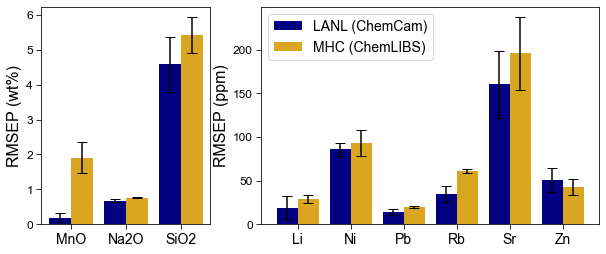

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


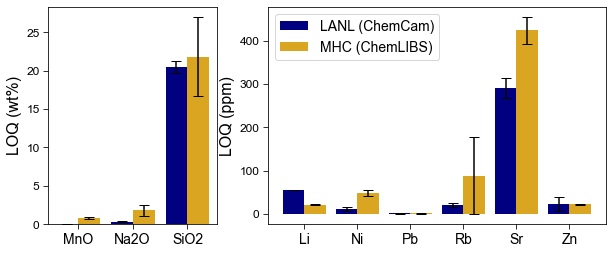

In [70]:
mhc_lanl('RMSEP')
mhc_lanl('LOQ')

### XY plot

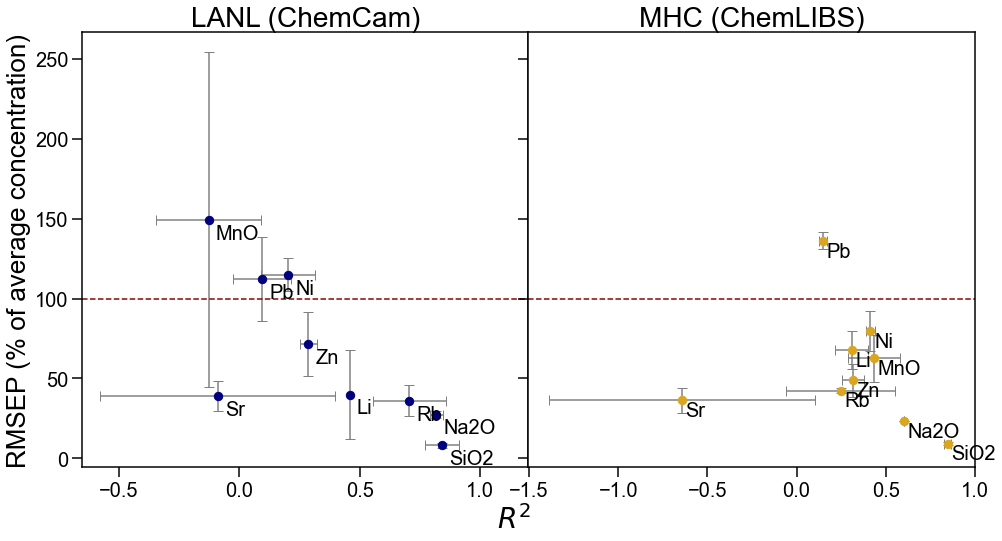

In [71]:
# def inst_compare(instrument):
fig, (lanl, mhc) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (16,8))

#sizes
labsize = 26
titlesize = 28
lwidth = 1.5
annot = 20
p_s = 70
tlen=10
cap=5
c_e = 'grey'
    
lanl.scatter(x = ldata.R2_Braga, y = ldata.RMSEP_per, c=c_l, s=p_s, zorder=3)
lanl.errorbar(x=ldata.R2_Braga, y = ldata.RMSEP_per, c=c_e, xerr=ldata.R2_Braga_sd, yerr=ldata.RMSEP_sd_per, capsize=cap, fmt='o', zorder=1)
lanl.set_xlim(right=1.2)
lanl.tick_params(labelsize=annot, width =lwidth, length = tlen)
lanl.set_ylabel("RMSEP (% of average concentration)", fontsize = labsize)
lanl.set_title(llabel, fontsize = titlesize)
lanl.axhline(y=100, xmin = 0, xmax = 1, color="darkred", linewidth=lwidth, linestyle = '--')

mhc.scatter(x = mdata.R2_Braga, y = mdata.RMSEP_per, c=c_m, s=p_s, zorder=4)
mhc.errorbar(x=mdata.R2_Braga, y = mdata.RMSEP_per, c=c_e, xerr=mdata.R2_Braga_sd, yerr=mdata.RMSEP_sd_per, capsize=cap, fmt='o', zorder=2)
mhc.set_title(mlabel, fontsize = titlesize)
mhc.set_xlim(right=1)
mhc.tick_params(labelsize=annot, width =lwidth, length = tlen)
mhc.axhline(y=100, xmin = 0, xmax = 1, color="darkred", linewidth=lwidth, linestyle = '--')

# add labels
for i in range(len(mdata.element)):
    mhc.text(mdata['R2_Braga'][i]+.02, mdata['RMSEP_per'][i]-10, mdata['element'][i], fontsize=annot)

for i in range(len(ldata.element)):
    lanl.text(ldata['R2_Braga'][i]+.03, ldata['RMSEP_per'][i]-12, ldata['element'][i], fontsize=annot)

# x axis label
fig.text(0.5, 0.02, r"$R^{2}$", ha = "center", fontsize = titlesize)

plt.subplots_adjust(wspace = 0, hspace =0)
plt.setp(mhc.spines.values(), linewidth=lwidth)
plt.setp(lanl.spines.values(), linewidth=lwidth)

# save image
path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\CC_CL_XY.eps"
path1 = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\CC_CL_XY.jpeg"
plt.savefig(path, bbox_inches="tight") # save as .eps
plt.savefig(path1, bbox_inches="tight") # save as .jpeg

plt.show()

# Atmosphere comparison
- Braga
- ChemLIBS
- LOQ and RMSE-P

In [72]:
data3 = data[data.instrument == 'ChemLIBS']
maj3 = data3[data3.element.isin(maj_list)].reset_index(drop=True)
min3 = data3[~data3.element.isin(maj_list)].reset_index(drop=True)

In [73]:
def maj_atm(atm, lotype):
    return maj3[maj3.atmosphere==atm][lotype]
    
def min_atm(atm, lotype):
    return min3[min3.atmosphere==atm][lotype]
    
def atmosphere(lotype):
    data = lotype + '_Braga'
    error = lotype + '_Braga_sd'
    
    # define plot stuff
    width = 0.14
    c_m = '#a8261d'
    c_e = '#34a9c7'
    c_v = '#757778'
    ysize = 12
    lsize = 14
    tsize = 16
    cap = 3

    #labels
    majlab = maj3.element.unique()
    minlab = min3.element.unique()

    # tick locations
    majt1 = [0, 0.5, 1] 
    majt2 = [x + width for x in majt1]
    majt3 = [x + width*2 for x in majt1]
    
    mint1 = np.arange(0,3,step=0.5)
    mint2 = [x + width for x in mint1]
    mint3 = [x + width*2 for x in mint1]
    
    majtk = [x + width for x in majt1]
    mintk = [x + width for x in mint1]

    # make figure
    fig, (maj, minor) = plt.subplots(ncols = 2, figsize = (10,4),
                                     # make major one smaller
                                     gridspec_kw={'width_ratios': [1,2]})
    # majors
    major1 = maj.bar(majt1, maj_atm('Mars', data), width, yerr=maj_atm('Mars', error), capsize=cap, label = "Mars", color = c_m)
    major2 = maj.bar(majt2, maj_atm('Earth', data), width, yerr=maj_atm('Earth', error), capsize=cap, label = "Earth", color = c_e)
    major3 = maj.bar(majt3, maj_atm('Vacuum', data), width, yerr=maj_atm('Vacuum', error), capsize=cap, label = "Vacuum", color = c_v)
    # minors
    minor1 = minor.bar(mint1, min_atm('Mars', data), width, yerr=min_atm('Mars', error), capsize=cap, label = "Mars", color = c_m)
    minor2 = minor.bar(mint2, min_atm('Earth', data), width, yerr=min_atm('Earth', error), capsize=cap, label = "Earth", color = c_e)
    minor3 = minor.bar(mint3, min_atm('Vacuum', data), width, yerr=min_atm('Vacuum', error), capsize=cap, label = "Vacuum", color = c_v)

    # formatting
    maj.tick_params(axis = 'y', which = 'major', labelsize = ysize)
    maj.tick_params(length=klen)
    maj.set_xticks(majtk)
    maj.set_xticklabels(majlab, fontsize = lsize)
    maj.set_ylabel((lotype + " (wt%)"), fontsize = tsize)

    minor.set_xticks(mintk)
    minor.set_xticklabels(minlab, fontsize = lsize)
    minor.set_ylabel((lotype + " (ppm)"), fontsize = tsize)
    minor.tick_params(axis = 'y', which = 'major', labelsize = ysize)  
    minor.tick_params(length=klen)
    minor.legend(handles = [major1, major2, major3], fontsize = lsize)

    # save image
    path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\"+lotype+"_atmosphere.eps"
    path1 = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\"+lotype+"_atmosphere.jpeg"
    plt.savefig(path, bbox_inches="tight") # save as .eps
    plt.savefig(path1, bbox_inches="tight") # save as .jpeg
    
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


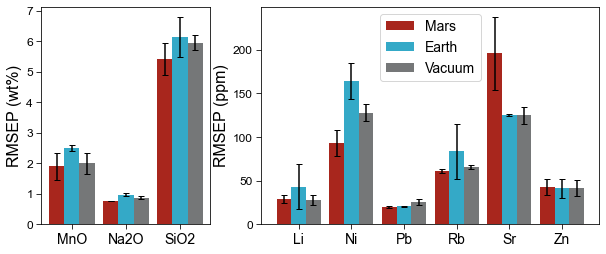

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


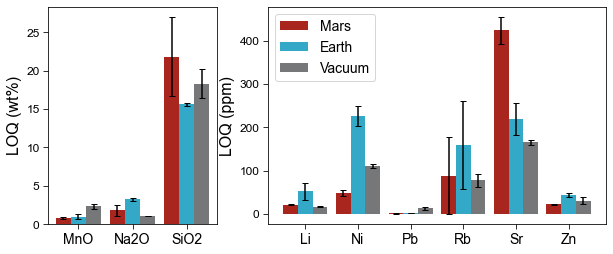

In [74]:
atmosphere('RMSEP')
atmosphere('LOQ')

# All predicted vs. true and regression vector plots

In [2]:
# generate comps
comps_path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\tables\\TableS1_sample_compositions.xlsx"
lanl_comps = pd.read_excel(comps_path, sheet_name = "LANL")
mhc_comps = pd.read_excel(comps_path, sheet_name = "MHC")
comps = pd.merge(mhc_comps, lanl_comps, how = "outer") # merge comps
comps.columns = comps.columns.map(lambda x: x.split()[0])
comps = comps.drop_duplicates(subset = 'Sample') # remove duplicates
comps['Sample'] = comps['Sample'].astype(str)
comps = comps.sort_values(by='Sample')
comps = comps.replace(np.nan, "", regex=True)
cols = comps.columns.drop('Sample')
comps[cols] = comps[cols].apply(pd.to_numeric) # make columns numeric

# make dictionary of spectrum names to sample names
key_path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\ChemLIBS_spectrum_no_to_name.csv"
mhc_key = pd.read_csv(key_path)
mhc_key = pd.Series(mhc_key.Sample.values, index=mhc_key.pkey).to_dict()

# make dictionary of 'Actual' uncertainties
unc_path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\BureauVeritasuncertainties_forpaper.csv"
uncert = pd.read_csv(unc_path)
uncert = pd.Series(uncert.uncertainty.values, index=uncert.element).to_dict()

#### Pred v. true
A lot similar to get_rmsep() in Full calculations notebook

In [16]:
def pred_true_plot(folder, file_list, data, comps, instrument, atmosphere, n_range):
    print('Making pred/true plots')
#-------------------------GET-DATA--------------------------#
    for file in tqdm(file_list):
        if "test" in file:
            path = (folder + file)
            df = pd.read_csv(path)

            # get element
            if "Composition:" in df.columns[1]:
                element = df.columns[1].split()[1]
            else: element = df.columns[1].split()[0]
            
            # format columns
            df.columns = ['pkey', 'Actual', 'Pred']
            df = df.drop([0])
            df.Pred = df.Pred.astype(float)  
            
            # remove predictions above 100 for majors
            if element in ['SiO2', 'MnO', 'Na2O']:
                df = df[df.Pred < 100]
            
            # rename ChemLIBS Spectrum names with sample names
            if df.pkey.str.contains('Spectrum').any():
                df = df.replace({'pkey': mhc_key})
            
            # format LANL spectra names to sample names
            else:
                df['pkey'] = df['pkey'].map(lambda x: x.split("_")[1])
                df['pkey'] = df['pkey'].map(lambda x: str(x).upper())
                
            # order columns
            df = df[['pkey', 'Actual', 'Pred']].drop_duplicates(subset = 'pkey').sort_values(by='pkey').reset_index(drop=True)
               
            # subselect relevant reference values
            ref = detail_data[(detail_data.num_range == n_range)&(detail_data.instrument == instrument)&(detail_data.atmosphere == atmosphere)&(detail_data.element == element)].reset_index(drop=True)
            # add in Actual concentrations
            temp_comps = comps[comps.Sample.isin(df.pkey)].reset_index(drop=True) 
            
            # remove samples that don't have composition info
            no_comps = df[~df.pkey.isin(temp_comps.Sample)]
            if len(no_comps) > 0:
                df = pd.concat([df, no_comps]).drop_duplicates(keep=False).reset_index(drop=True)
            
            df['Actual'] = temp_comps[temp_comps['Sample'] == df['pkey']][element]
            
            # remove NaN Actual values....which idk why they'd be there
            df = df.dropna()
            
            # get Braga and metals LDBQ
            loq_b = ref['LOQ_Braga'].iloc[0]
            lob_b = ref['LOB_Braga'].iloc[0]
            lod_b = ref['LOD_Braga'].iloc[0]
            loq_b = ref['LOQ_Braga'].iloc[0]
            lob_m = ref['LOB_metals'].iloc[0]
            lod_m = ref['LOD_metals'].iloc[0]
            loq_m = ref['LOQ_metals'].iloc[0]

#----------------------------MAKE-PLOT------------------------------#
            path_name = instrument+"_"+atmosphere+"\\"
            fig_name = element+"_"+n_range

            xlab = "True "+element
            ylab = "Predicted "+element
            xdata = df.Actual
            ydata = df.Pred
            xerr = uncert[element] # 'Actual' uncertainty
            yerr = ref['RMSEP_Braga'].iloc[0] # RMSEP
            b_type = 'dotted'
            d_type = 'dashed'
            q_type = 'solid'
            ddash = (0, (10, 2))
            c_b = '#3a2382'
            c_m = '#f58442'
            c_p = "black"
            c_g = "darkgrey"
            c_e = "#bfbfbf"
            linew = 0.5
            line_c = 'white'
            lwidth = 1.5
            cap = 2.5
            xsize = 20
            klen = 5

            fig, ax = plt.subplots(1, figsize = (6,6))
            # plot data
            ax.scatter(xdata, ydata, c=c_p, linewidth = linew, edgecolors = line_c, zorder=2)
            # error bars
            ax.errorbar(x=xdata, y=ydata, c=c_e, xerr=xerr, yerr=yerr, fmt = '.', capsize=cap, zorder=1)
            # 1:1 line
            y_bot, y_top = plt.ylim() # get current auto-axes
            x_bot, x_top = plt.xlim()
            # make sure LDBQ not below edge
            top = max(y_top, x_top, loq_b+(0.1*loq_b), loq_m+(0.1*loq_m))
            bot = min(y_bot, x_bot, 0)
            plt.xlim(x_bot, x_top) # reset to original axes
            plt.ylim(y_bot, y_top)
            one_one = ax.plot([bot,top], [bot,top], c=c_p, linewidth=lwidth, linestyle = ddash, label = "1:1")

            # plot lines
            zero = ax.axhline(y=0, xmin=0, xmax=1, c=c_p, linewidth=1, linestyle = q_type)
            lobb_line = ax.axhline(y=lob_b, xmin = 0, xmax = 1, c=c_b, linewidth=lwidth, linestyle = b_type, label = "Braga LOB")
            lodb_line = ax.axhline(y=lod_b, xmin = 0, xmax = 1, c=c_b, linewidth=lwidth, linestyle = d_type, label = "Braga LOD")
            loqb_line = ax.axhline(y=loq_b, xmin = 0, xmax = 1, c=c_b, linewidth=lwidth, linestyle = q_type, label = "Braga LOQ")
            lobm_line = ax.axhline(y=lob_m, xmin = 0, xmax = 1, c=c_m, linewidth=lwidth, linestyle = b_type, label = "Metals LOB")
            lodm_line = ax.axhline(y=lod_m, xmin = 0, xmax = 1, c=c_m, linewidth=lwidth, linestyle = d_type, label = "Metals LOD")
            loqm_line = ax.axhline(y=loq_m, xmin = 0, xmax = 1, c=c_m, linewidth=lwidth, linestyle = q_type, label = "Metals LOQ")

            # format
            ax.set_xlabel(xlab, fontsize = xsize)
            ax.set_ylabel(ylab, fontsize = xsize)
            ax.tick_params(length=klen, labelsize=tsize)

            plt.tight_layout()
            plt.savefig("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\pred_true\\"+path_name+fig_name+".eps", dpi=600)
            plt.savefig("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\pred_true\\"+path_name+fig_name+".jpg", dpi=600)
            plt.close(fig)

#### Regression vector

In [7]:
def reg_plot(folder, file_list, instrument, atmosphere, n_range):
    print('Making regression vector plots')
#-------------------------GET-DATA--------------------------#
    for file in tqdm(file_list):
        if "coeff" in file:
            path = (folder + file)
            df = pd.read_csv(path)
    
            # format data
            df = df.reset_index().transpose()
            df.columns = df.iloc[0]
            df = df.drop(df.index[0]).reset_index(drop=True)

            # get element info
            if "Composition:" in df.columns[1]:
                element = df.columns[1].split()[1]
            else: element = df.columns[1].split()[0]
            df.columns.values[1] = element # rename column

#----------------------------MAKE-PLOT------------------------------#
            path_name = instrument+"_"+atmosphere+"\\"
            fig_name = element+"_"+n_range
            
            xdata = df['wavelength']
            ydata = df[element]
            c_p = 'black'
            xlab = 'Wavelength (nm)'
            ylab = 'Weight (A.U.)'
            title = element+": "+instrument+" "+atmosphere+" "+n_range
            xsize=20

            fig, ax = plt.subplots(1, figsize = (10,6))
            ax.plot(xdata, ydata, c = c_p)
            ax.set_xlabel(xlab, fontsize = xsize)
            ax.set_ylabel(ylab, fontsize = xsize)
            ax.tick_params(length=klen, labelsize=tsize)
            plt.title(title, fontsize=tsize)

            # save
            plt.tight_layout()
            plt.savefig("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\regression_vectors\\"+path_name+fig_name+".eps", dpi=600)
            plt.savefig("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\regression_vectors\\"+path_name+fig_name+".jpg", dpi=600)
            plt.close(fig)

In [19]:
envs = [['LANL', 'Mars'],['ChemLIBS', 'Mars'],['ChemLIBS', 'Earth'],['ChemLIBS', 'Vacuum']]

for env in envs:
    
    instrument = env[0]
    atmosphere = env[1]
    
    for n_range in ['0-750', '250-1000']:
        print('Running',  instrument, atmosphere, n_range)
        
        folder = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\"+instrument+" calculations\\models\\"+atmosphere+"\\"+n_range+"\\"
        file_list = os.listdir(folder)    

        pred_true_plot(folder, file_list, data, comps, instrument, atmosphere, n_range)
        #reg_plot(folder, file_list, instrument, atmosphere, n_range)

Running LANL Mars 0-750
Making pred/true plots


  0%|          | 0/37 [00:00<?, ?it/s]

Running LANL Mars 250-1000
Making pred/true plots


  0%|          | 0/37 [00:00<?, ?it/s]

Running ChemLIBS Mars 0-750
Making pred/true plots


  0%|          | 0/28 [00:00<?, ?it/s]

Running ChemLIBS Mars 250-1000
Making pred/true plots


  0%|          | 0/28 [00:00<?, ?it/s]

Running ChemLIBS Earth 0-750
Making pred/true plots


  0%|          | 0/28 [00:00<?, ?it/s]

Running ChemLIBS Earth 250-1000
Making pred/true plots


  0%|          | 0/28 [00:00<?, ?it/s]

Running ChemLIBS Vacuum 0-750
Making pred/true plots


  0%|          | 0/28 [00:00<?, ?it/s]

Running ChemLIBS Vacuum 250-1000
Making pred/true plots


  0%|          | 0/28 [00:00<?, ?it/s]

# Example pred/true, reg vector figures
ChemLIBS Mars Li
### Regression vector

In [ ]:
# 0-750 regression vector
coeffs750 = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\ChemLIBS calculations\\models\\Mars\\0-750\\Li_coeffs.csv")
coeffs750 = coeffs750.reset_index().transpose()
coeffs750.columns = coeffs750.iloc[0]
coeffs750 = coeffs750.drop(coeffs750.index[0]).reset_index(drop=True)
coeffs750.columns = ['wave', '0-750']
# 250-1000 regression vector
coeffs250 = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\ChemLIBS calculations\\models\\Mars\\250-1000\\Li_coeffs.csv")
coeffs250 = coeffs250.reset_index().transpose()
coeffs250.columns = coeffs250.iloc[0]
coeffs250 = coeffs250.drop(coeffs250.index[0]).reset_index(drop=True)
coeffs250.columns = ['wave', '250-1000']
# merge
coeffs = pd.merge(coeffs750, coeffs250, on='wave')
# add CADILLAC spectrum
cad.columns = ['wave', 'CADILLAC']
coeffs = pd.merge(coeffs, cad, on='wave')
coeffs['CADILLAC'] = coeffs['CADILLAC'] * 100000 # make larger to match scale

In [ ]:
# data
wave = coeffs['wave']
cf_750 = coeffs['0-750']
cf_250 = coeffs['250-1000']
cadillac = coeffs['CADILLAC']
# format
c_cad = 'black'
c_750 = 'darkgreen'
c_250 = 'lightgreen'
xlab = 'Wavelength (nm)'
ylab = 'Weight or Normalized Intensity (A.U.)'
xsize=20
lsize=14
a = 0.6
l_cad = 'CADILLAC'
l_750 = '0-750 Regression Vector'
l_250 = '250-1000 Regression Vector'

fig, ax = plt.subplots(1, figsize = (10,6))
ax.plot(wave, cadillac, c = c_cad, alpha = a, zorder = 1, label = l_cad)
ax.plot(wave, cf_750, c = c_750, zorder = 2, label = l_750)
ax.plot(wave, cf_250, c = c_250, alpha = a, zorder = 3, label = l_250)
ax.set_xlim(240,855)
ax.set_xlabel(xlab, fontsize = xsize)
ax.set_ylabel(ylab, fontsize = xsize)
ax.tick_params(length=klen, labelsize=tsize)
ax.legend(fontsize = lsize, loc=(0.27,0.77))

# save image
path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\reg_vector_compare.eps"
path1 = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\reg_vector_compare.jpeg"
plt.savefig(path, bbox_inches="tight") # save as .eps
plt.savefig(path1, bbox_inches="tight") # save as .jpeg

plt.show()

### Pred/true

In [ ]:
element = 'Li'
instrument = 'ChemLIBS'
atmosphere = 'Mars'
xerr = uncert[element]

# 0-750 predictions
pred_true_750 = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\ChemLIBS calculations\\models\\Mars\\0-750\\Li_test_predictions.csv")
pred_true_750.columns = ['pkey', 'Actual', 'Pred']
pred_true_750 = pred_true_750.drop([0])
pred_true_750.Pred = pred_true_750.Pred.astype(float)
# compositions
pred_true_750 = pred_true_750.replace({'pkey': mhc_key})
pred_true_750 = pred_true_750[['pkey', 'Actual', 'Pred']].drop_duplicates(subset = 'pkey').sort_values(by='pkey').reset_index(drop=True)
# add in Actual concentrations
temp_comps = comps[comps.Sample.isin(pred_true_750.pkey)].reset_index(drop=True) 
pred_true_750['Actual'] = temp_comps[temp_comps['Sample'] == pred_true_750['pkey']][element]
# get RMSEP
ref_750 = detail_data[(detail_data.num_range == '0-750')&(detail_data.instrument == instrument)&(detail_data.atmosphere == atmosphere)&(detail_data.element == element)].reset_index(drop=True)
err_750 = ref_750['RMSEP_Braga'].iloc[0]

# 250-1000 predictions
pred_true_250 = pd.read_csv("C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\ChemLIBS calculations\\models\\Mars\\250-1000\\Li_test_predictions.csv")
pred_true_250.columns = ['pkey', 'Actual', 'Pred']
pred_true_250 = pred_true_250.drop([0])
pred_true_250.Pred = pred_true_250.Pred.astype(float)
# compositions
pred_true_250 = pred_true_250.replace({'pkey': mhc_key})
pred_true_250 = pred_true_250[['pkey', 'Actual', 'Pred']].drop_duplicates(subset = 'pkey').sort_values(by='pkey').reset_index(drop=True)
# add in Actual concentrations
temp_comps = comps[comps.Sample.isin(pred_true_250.pkey)].reset_index(drop=True) 
pred_true_250['Actual'] = temp_comps[temp_comps['Sample'] == pred_true_250['pkey']][element]
# get RMSEP
ref_250 = detail_data[(detail_data.num_range == '250-1000')&(detail_data.instrument == instrument)&(detail_data.atmosphere == atmosphere)&(detail_data.element == element)].reset_index(drop=True)
err_250 = ref_250['RMSEP_Braga'].iloc[0]

In [13]:
# data
x_750 = pred_true_750['Actual']
y_750 = pred_true_750['Pred']
x_250 = pred_true_250['Actual']
y_250 = pred_true_250['Pred']
# format
c_750 = 'darkgreen'
c_250 = 'lightgreen'
xlab = 'Actual Li (ppm)'
ylab = 'Predicted Li (ppm)'
xsize=20
lsize=14
ddash = (0, (10, 2))
l_type = 'solid'
a = 0.6
c_e = "#bfbfbf"
c_g = "darkgrey"
c_p = 'black'
linew = 0.5
lwidht = 1
line_c = 'white'
cap = 2.5
l_750 = '0-750 Model'
l_250 = '250-1000 Model'

fig, ax = plt.subplots(1, figsize = (6,6))
# data
ax.scatter(x_750, y_750, c = c_750, linewidth = linew, alpha = a, edgecolors = line_c, label = l_750, zorder=4)
ax.scatter(x_250, y_250, c = c_250, linewidth = linew, edgecolors = line_c, label = l_250, zorder=3)
ax.axhline(y=0, xmin=0, xmax=1, c=c_p, linewidth=1, linestyle = l_type) # 0 line

# error bars (line for each model bc too much overlap otherwise)
#ax.errorbar(x=x_750, y=y_750, c=c_e, xerr=xerr, yerr=err_750, alpha = a, capsize=cap, fmt='o', zorder=1)
#ax.errorbar(x=x_250, y=y_250, c=c_e, xerr=xerr, yerr=err_250, alpha = a, capsize=cap, fmt='o', zorder=2)
ax.errorbar(x=210, y=65, c=c_250, xerr=0, yerr=err_250, capsize=3)
ax.errorbar(x=180, y=65, c=c_750, xerr=0, yerr=err_750, capsize=3)

# 1:1 line
y_bot, y_top = ax.get_ylim() # get current auto-axes
x_bot, x_top = ax.get_xlim()
top = max(y_top, x_top)
bot = min(y_bot, x_bot, 0)
ax.set_xlim(x_bot, x_top) # reset to original axes
ax.set_ylim(y_bot, y_top)
ax.plot([bot,top], [bot,top], c=c_p, linewidth=lwidth, linestyle = ddash, label = "1:1")

# formatting
ax.set_xlabel(xlab, fontsize = xsize)
ax.set_ylabel(ylab, fontsize = xsize)
ax.tick_params(length=klen, labelsize=lsize)
ax.legend(fontsize = lsize)

# save image
path = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\pred_true_compare.eps"
path1 = "C:\\Users\\ytsma22c\\Google Drive\\Darby Work\\LOD paper\\figures\\pred_true_compare.jpeg"
plt.savefig(path, bbox_inches="tight") # save as .eps
plt.savefig(path1, bbox_inches="tight") # save as .jpeg

plt.show()

NameError: name 'pred_true_750' is not defined